# Distance and Approximations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from sktime.datasets import load_UCR_UEA_dataset

## Load the data

---
Load the Cylinder-Bell-Funnel (CBF) dataset either using the `load_UCR_UEA_dataset` function or by loading the data from the `data` folder. 

If you use the `load_UCR_UEA_dataset` function, be sure to set the `return_type` parameter to `numpy3D`. If you load the data locally, you can use the `np.load` function.

Be sure to load both the data and the classes. Store the data in a variable `X` and the classes in a variable `classes`. X should contain 930 univariate time series of length 128. The classes should contain the class labels for each time series.

In [2]:
# load Cylinder-Bell-Funnel dataset
X, classes = np.load('/home/giuseppe/pmts/notebooks/data/CBF_data.npy'), np.load('/home/giuseppe/pmts/notebooks/data/CBF_classes.npy')
print(X.shape)
print(classes.shape)

(930, 1, 128)
(930,)


---

Store the first two time series of the dataset in the variables `ts1` and `ts2`. Plot the time series.

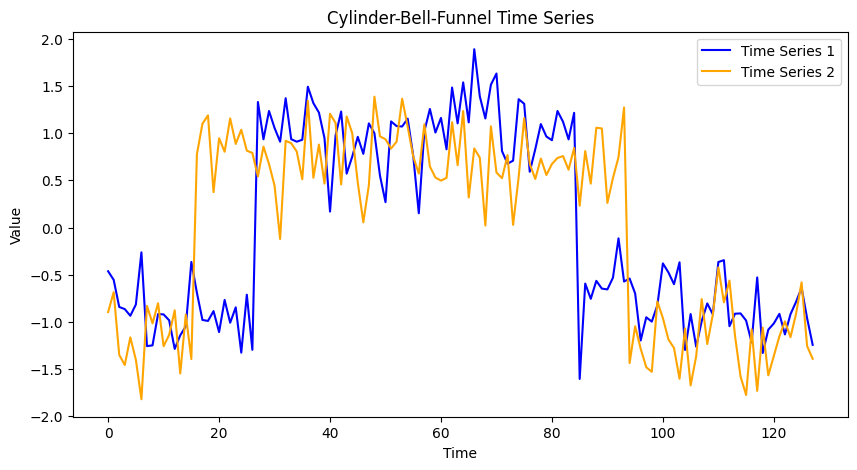

In [3]:
ts1 = X[0,0, :]
ts2 = X[1,0, :]

# plot the time series
plt.figure(figsize=(10, 5))
plt.plot(ts1, label='Time Series 1', color='blue')
plt.plot(ts2, label='Time Series 2', color='orange')
plt.title('Cylinder-Bell-Funnel Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

## Distances

In [4]:
from sktime.distances import distance

---

Calculate all the distances you saw in the lecture between `ts1` and `ts2`.

In [6]:
dist_eucl = distance(ts1, ts2, metric='euclidean')
dist_dtw = distance(ts1, ts2, metric='dtw')
dist_dtw_w = distance(ts1, ts2, metric='dtw', window=0.2)
dist_dtw_ims = distance(ts1, ts2, metric='dtw', itakura_max_slope=0.2)

print(f"Euclidean distance: {dist_eucl}")
print(f"DTW distance: {dist_dtw}")
print(f"DTW distance with window: {dist_dtw_w}")
print(f"DTW distance with Itakura slope: {dist_dtw_ims}")

Euclidean distance: 9.44936449845677
DTW distance: 10.71388858114709
DTW distance with window: 10.71388858114709
DTW distance with Itakura slope: 10.739584695674464


### Alignment

In [7]:
from sktime.alignment.dtw_numba import AlignerDtwNumba

---

Visualize the alignments for the DTW distance, using a sakoe-chiba window of 0.1.

In [8]:
aligner = AlignerDtwNumba(window=0.1)
aligner.fit([pd.DataFrame(ts1), pd.DataFrame(ts2)])
alignments = aligner.get_alignment()
aligned_1, aligned_2 = aligner.get_aligned()

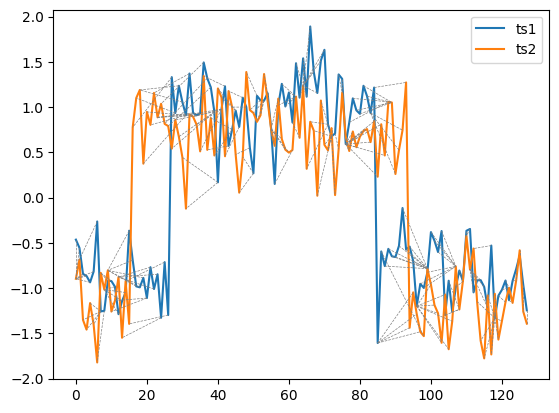

In [9]:
plt.plot(ts1, c="C0", label="ts1")
plt.plot(ts2, c="C1", label="ts2")
for index, row in alignments.iterrows():
    ind0 = row['ind0']
    ind1 = row['ind1']
    plt.plot([ind0, ind1], [ts1[ind0], ts2[ind1]], color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

## Approximation

In [10]:
from sktime.transformations.series.paa import PAA
from sktime.transformations.series.sax import SAX
from pyts.approximation import DiscreteFourierTransform
from sklearn.preprocessing import StandardScaler
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
def dft_inverse_trasform(X_dft, n_coefs, n_timestamps):
    # https://pyts.readthedocs.io/en/latest/auto_examples/approximation/plot_dft.html
    n_samples = X_dft.shape[0]
    if n_coefs % 2 == 0:
        real_idx = np.arange(1, n_coefs, 2)
        imag_idx = np.arange(2, n_coefs, 2)
        X_dft_new = np.c_[
            X_dft[:, :1],
            X_dft[:, real_idx] + 1j * np.c_[X_dft[:, imag_idx],
                                            np.zeros((n_samples, ))]
        ]
    else:
        real_idx = np.arange(1, n_coefs, 2)
        imag_idx = np.arange(2, n_coefs + 1, 2)
        X_dft_new = np.c_[
            X_dft[:, :1],
            X_dft[:, real_idx] + 1j * X_dft[:, imag_idx]
        ]
    X_irfft = np.fft.irfft(X_dft_new, n_timestamps)
    return X_irfft

---
As you probably saw, the time series are very noisy. Your goal here is to denoise them, without losing too much information. If you did things correctly, you should be able to see that the two time series you analized are quite similar. Now store the fourth time series (so `i=3`) in the variable `ts3` and plot it.

In [14]:
ts3 = X[3, 0, :]

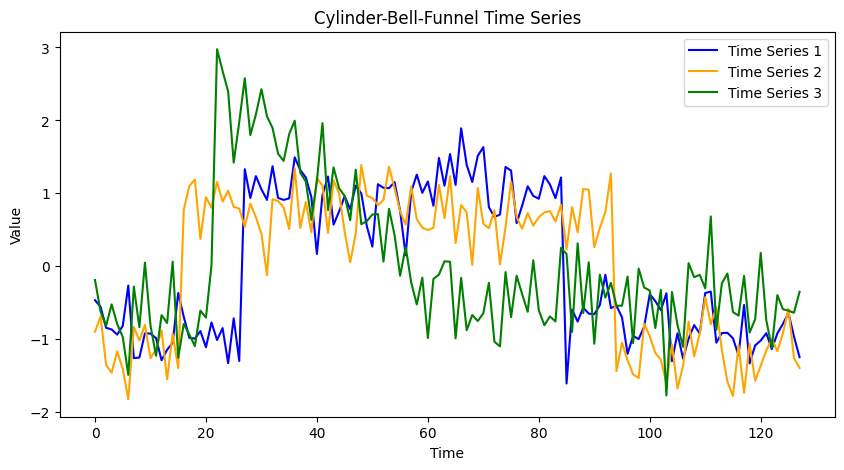

In [15]:
# plot ts1, ts2, ts3
plt.figure(figsize=(10, 5))
plt.plot(ts1, label='Time Series 1', color='blue')
plt.plot(ts2, label='Time Series 2', color='orange')
plt.plot(ts3, label='Time Series 3', color='green')
plt.title('Cylinder-Bell-Funnel Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

---
You should be able to see that ts1 and ts2 are quite similar, while ts3 is quite different.

Your goal here is to approximate `ts1`, `ts2` and `ts3` using one method between PAA, SAX, DFT, such that you remove the noise but maintain the general shape of the time series. At the end `ts1_approx` and `ts2_approx` should still be similar, while `ts3_approx` should be quite different.

---

1. Approximate `ts1`, `ts2` and `ts3` using one method between PAA, SAX, DFT.

In [22]:
# Standardize the time series ts1, ts2, ts3
scaler = StandardScaler()
ts1 = scaler.fit_transform(ts1.reshape(-1, 1)).flatten()
ts2 = scaler.fit_transform(ts2.reshape(-1, 1)).flatten()
ts3 = scaler.fit_transform(ts3.reshape(-1, 1)).flatten()

In [23]:
n_coefs = 20
dft = DiscreteFourierTransform(n_coefs=n_coefs)

coefs1 = dft.fit_transform(ts1.reshape(1, -1))
coefs2 = dft.fit_transform(ts2.reshape(1, -1))
coefs3 = dft.fit_transform(ts3.reshape(1, -1))

ts1_approx = dft_inverse_trasform(coefs1, n_coefs, len(ts1))
ts2_approx = dft_inverse_trasform(coefs2, n_coefs, len(ts2))
ts3_approx = dft_inverse_trasform(coefs3, n_coefs, len(ts3))

---

2. Plot the original time series and the approximated time series (`ts1` with `ts1_approx`, `ts2` with `ts2_approx`, `ts3` with `ts3_approx`). Then plot all the approximations in the same plot.

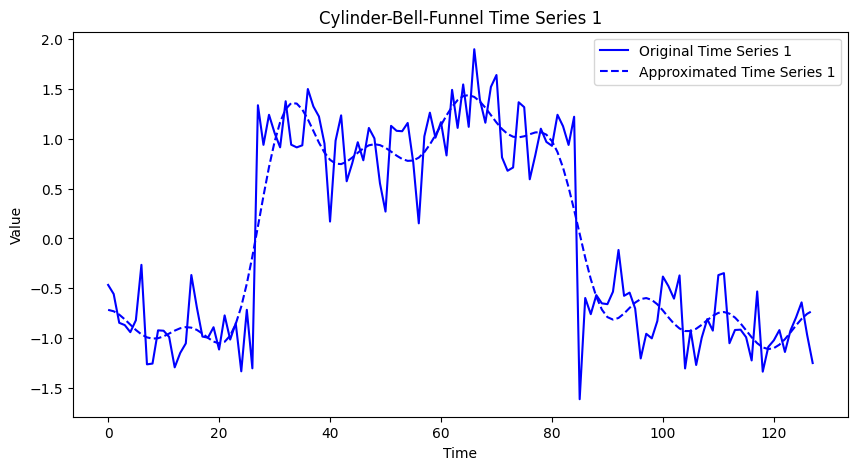

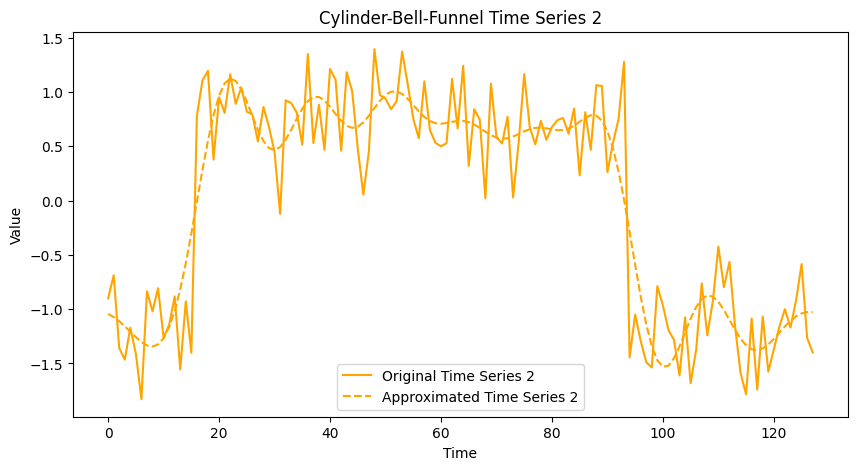

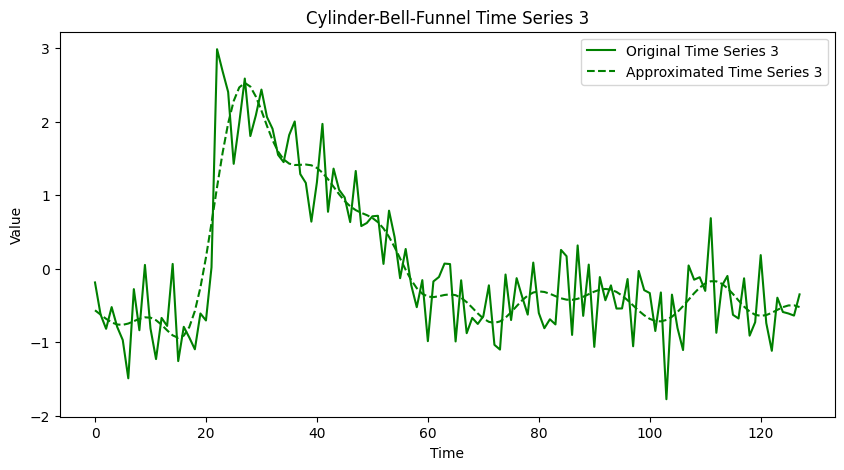

In [24]:
# plot the original and approximated time series
plt.figure(figsize=(10, 5))
plt.plot(ts1, label='Original Time Series 1', color='blue')
plt.plot(ts1_approx.ravel(), label='Approximated Time Series 1', color='blue', linestyle='--')
plt.title('Cylinder-Bell-Funnel Time Series 1')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(ts2, label='Original Time Series 2', color='orange')
plt.plot(ts2_approx.ravel(), label='Approximated Time Series 2', color='orange', linestyle='--')
plt.title('Cylinder-Bell-Funnel Time Series 2') 
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(ts3, label='Original Time Series 3', color='green')
plt.plot(ts3_approx.ravel(), label='Approximated Time Series 3', color='green', linestyle='--')
plt.title('Cylinder-Bell-Funnel Time Series 3')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

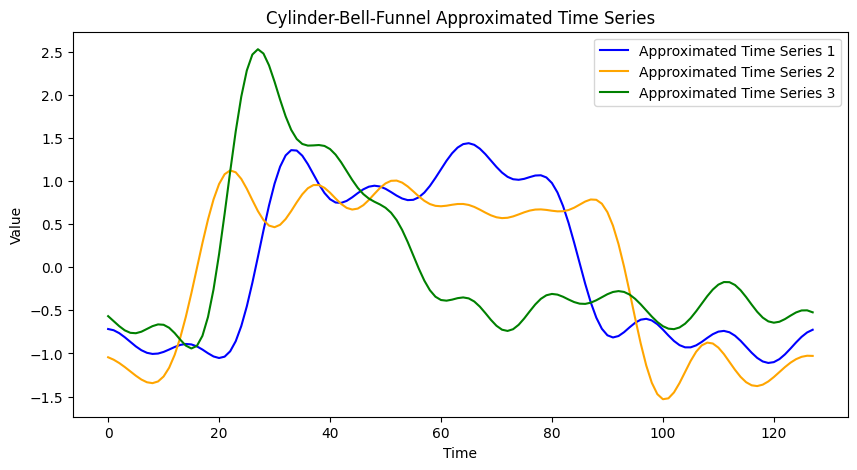

In [25]:
# plot the approximated time series
plt.figure(figsize=(10, 5))
plt.plot(ts1_approx.ravel(), label='Approximated Time Series 1', color='blue')
plt.plot(ts2_approx.ravel(), label='Approximated Time Series 2', color='orange')
plt.plot(ts3_approx.ravel(), label='Approximated Time Series 3', color='green')
plt.title('Cylinder-Bell-Funnel Approximated Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

---
3. Evaluate the results qualititatively by looking at the plots, and by computing the dtw distance between `ts1_approx` and `ts2_approx`, and between `ts1_approx` and `ts3_approx`.

In [26]:
dist_dtw_12 = distance(ts1_approx, ts2_approx, metric='dtw')
dist_dtw_13 = distance(ts1_approx, ts3_approx, metric='dtw')
dist_dtw_23 = distance(ts2_approx, ts3_approx, metric='dtw')

print(f"DTW distance between approximated ts1 and ts2: {dist_dtw_12}")
print(f"DTW distance between approximated ts1 and ts3: {dist_dtw_13}")
print(f"DTW distance between approximated ts2 and ts3: {dist_dtw_23}")

DTW distance between approximated ts1 and ts2: 4.829304962603283
DTW distance between approximated ts1 and ts3: 11.967008767758376
DTW distance between approximated ts2 and ts3: 29.646341537418184


---
Now approximate the entire dataset (`X`) using PCA. You can use the `PCATransformer` from sktime. Find the number of components that explain at least 70% of the variance. Then, approximate the dataset using that number of components.

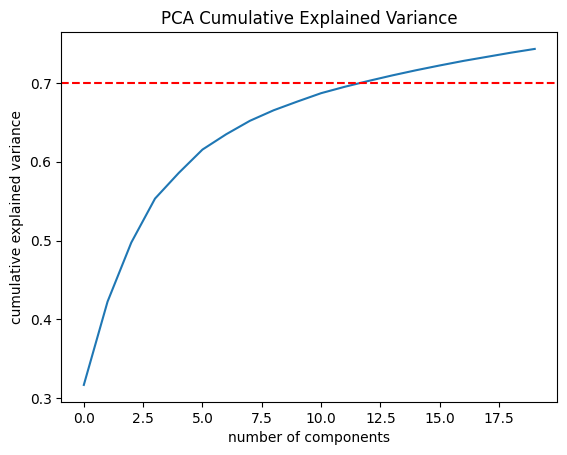

In [33]:
from sktime.transformations.panel.pca import PCATransformer

X_scaled = TabularToSeriesAdaptor(StandardScaler(), fit_in_transform=True).fit_transform(X)
pca = PCATransformer(n_components=20, random_state=0)
X_pca = pca.fit_transform(X_scaled)

plt.plot(np.cumsum(pca.pca.explained_variance_ratio_))
plt.axhline(y=0.7, color='r', linestyle='--')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('PCA Cumulative Explained Variance')
plt.show()

n_components = 13
pca = PCATransformer(n_components=n_components, random_state=0)
X_pca = pca.fit_transform(X_scaled)

---

Plot `ts1` and its approximation using PCA.

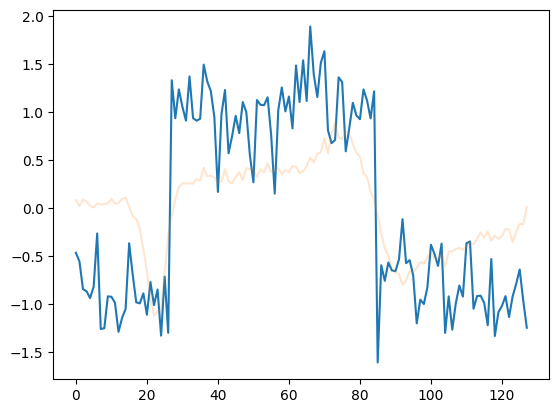

In [34]:
plt.plot(X[0,0,:].T, color="C0")
plt.plot(X_pca[0,0,:].T, color="C1", alpha=0.2) 
plt.show()

---
Now use `Tabularizer`and `PCA` with 2 components to compress the dataset. Then, plot the compressed dataset. Use the class labels to color the points.

In [35]:
from sktime.transformations.panel.reduce import Tabularizer
from sklearn.decomposition import PCA

In [36]:
pca_compressor = Tabularizer() * PCA(2, random_state=0)
pca_compressor

TransformerPipeline(steps=[Tabularizer(),
                           TabularToSeriesAdaptor(transformer=PCA(n_components=2, random_state=0))])

In [37]:
X_compressed = pca_compressor.fit_transform(X_scaled).to_numpy()
X_compressed.shape

(930, 2)

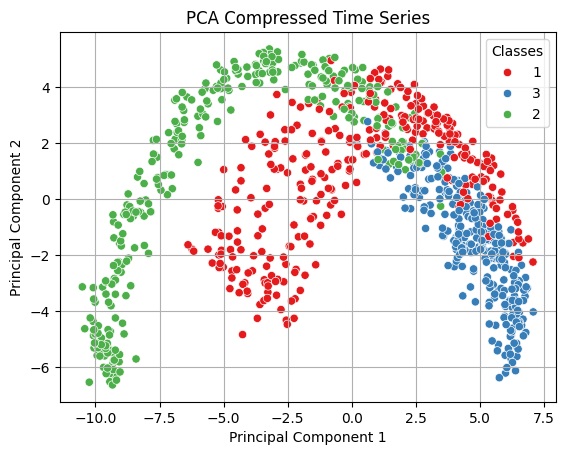

In [ ]:
sns.scatterplot(x=X_compressed[:, 0], y=X_compressed[:, 1], hue=classes, palette='Set1')
plt.title('PCA Compressed Time Series')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Classes')
plt.grid()
plt.show()

## Distance-based Classification

In [40]:
from sktime.datasets import load_UCR_UEA_dataset
from sktime.transformations.series.summarize import SummaryTransformer
from sklearn.neighbors import KNeighborsClassifier
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

---
In the following, we used a very simple SummaryTransformer to convert the time series into a tabular form and used a KNN classifier to classify the time series.

For this exercise you want to maximize accuracy and also runtime. Your goal is to beat our SummaryTransformer + KNN classifier. You can use any normalization, approximation and feature extraction method you want. The only constraint is that you should use the same classifier. You can use KNN directly on the time series (KNeighborsTimeSeriesClassifier), or perform a tabular conversion in some way (as we did for the SummaryTransformer) and then use a standard KNN from sklearn (KNeighborsClassifier).

- Can you find a model that is more accurate?
- Can you find a model that is faster and more accurate?
- Can you find a model that is faster, uses less features and is more accurate?

**Note 1:** You can use the `%%time` magic command to measure the time it takes to run a cell. You have to count all the transformations and the training/test time.

**Note 2:** Training has to be done only on the training set, and the test set should be used only for evaluation.

In [41]:
X_train, y_train = load_UCR_UEA_dataset("CBF", split="TRAIN", return_type="numpy3D")
X_test, y_test = load_UCR_UEA_dataset("CBF", split="TEST", return_type="numpy3D")
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((30, 1, 128), (30,), (900, 1, 128), (900,))

In [42]:
summary = SummaryTransformer()

In [43]:
%%time
X_features_train = summary.fit_transform(X_train)
X_features_test = summary.transform(X_test)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_features_train, y_train)
y_pred = knn.predict(X_features_test)

CPU times: user 5.79 s, sys: 4.14 ms, total: 5.8 s
Wall time: 5.8 s


In [44]:
accuracy_score(y_test, y_pred)

0.6633333333333333

In [45]:
print("n_features:", X_features_train.shape[1])

n_features: 9


---
Good luck!

## Discussion

---

What's the effect of dynamic time warping when comparing time series? Was it useful in this dataset? Why?

Which approximation method did you use? Did it work well? Why?

Did approximation make the time series more similar?

What can you grasp from the 2d representation of the dataset using PCA?

What was the best method you found for classification? Why do you think it worked better than the others?